# A Simple Model

In [189]:
import pandas as pd
from sklearn import base
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [103]:
from typing import List, Union, Tuple, Dict

In [3]:
RANDOM_STATE = 42

In [4]:
train_df_path = "data/train.csv"
test_df_path = "data/test.csv"

Here are the features in the data:

```
survived - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

In [63]:
# Constant
index_col = 'passengerid'
drop_cols = ["name", "sibsp", "parch", "ticket"]
target_col = "survived"
target_names = ["died", target_col]
cat_cols = ["sex", "cabin", "embarked"]

## Functions

In [7]:
def _sanitize_columns(
    df_columns: List[str] # the current column names
) -> List[str]: # sanitized column names
    return [c.strip().replace("/", "_per_").replace(" ", "_").lower() for c in df_columns]

In [14]:
cols = 'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked'.strip().split(',')
_sanitize_columns(cols)

['passengerid',
 'survived',
 'pclass',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked']

In [149]:
cols_test = list(set(cols) - set(['Survived']))

In [15]:
_sanitize_columns(["hello world","revenue/user", "CamelCase"])

['hello_world', 'revenue_per_user', 'camelcase']

### for Feature Engineering

In [ ]:
# print("Engineering features...")
# y = df_train[obj_col]
# train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
# test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
# train_df, test_df, mappings = to_category(train_df, test_df)

In [56]:
def input_data(
    raw_data: pd.DataFrame, # just loaded raw dataframe, could be fron anywhere
    cols: List[str], # columns from the dataframe to consider and sanitize. Must contain index_col.
    index_col: str # column to use as unique index
) -> pd.DataFrame: # sanitized dataframe
    df = raw_data.copy()[cols]
    df.columns = _sanitize_columns(cols)
    return df.set_index(index_col)

In [18]:
def target(
    input_data: pd.DataFrame, # input dataframe,
    target_col: str # this is the column that we want from the dataframe
) -> pd.Series: # return series corresponding to target
    return data[target_col]

In [138]:
def features(
    input_data: pd.DataFrame, # input dataframe,
    target_col: str, # this is the column that we want from the dataframe
) -> pd.DataFrame: # return dataframe corresponding to the feature matrix
    if target_col in input_data.columns:
        return input_data.drop([target_col], axis=1)
    return input_data

In [20]:
def cabin_t(
    cabin: pd.Series # raw cabin info
) -> pd.Series: # transformed cabin info
    return cabin.apply(lambda x: x[:1] if x is not np.nan else np.nan)

In [21]:
def ticket_t(
    ticket: pd.Series # raw ticket number
) -> pd.Series: # transformed ticket number
    return ticket.apply(lambda x: str(x).split()[0])

In [22]:
def family(
    sibsp: pd.Series, # number of siblings
    parch: pd.Series # number of parents/children
) -> pd.Series: # number of people in family
    return sibsp + parch

In [24]:
def _label_encoder(
    input_series: pd.Series # series to categorize
) -> preprocessing.LabelEncoder: # sklearn label encoder
    le = preprocessing.LabelEncoder()
    le.fit(input_series)
    return le

In [79]:
def _label_transformer(
    fit_le: preprocessing.LabelEncoder, # a fit label encoder
    input_series: pd.Series # series to transform 
) -> pd.Series: # transformed series
    return fit_le.transform(input_series)

In [152]:
def transformed_features(
    universe: pd.DataFrame, # a dataframe with categorical columns that capture all categorical levels
    features: pd.DataFrame, # input feature matrix
    cat_cols: List[str], # columns to categorize)
    cabin_t: pd.Series, # transformed cabin number
    ticket_t: pd.Series, # transformed ticket number
    labelencoders = Union[List[preprocessing.LabelEncoder], None] # Label Encoders if fit, else None
) -> Tuple[pd.DataFrame, List[preprocessing.LabelEncoder]] : # engineered features and labelencoders
    df = features.copy().drop(['cabin', 'ticket']+cat_cols, axis=1)
    df['cabin'] = cabin_t
    df['ticket'] = ticket_t
    if labelencoders is None:
        les = [None]*len(cat_cols)
    else:
        les = labelencoders
    againles = []
    for col, le in zip(cat_cols, les):
        if le == None:
            le = _label_encoder(universe[col])
        df[col] = _label_transformer(le, features[col])
        againles.append(le)
    return df, againles

In [86]:
def engineered_features(
    transformed_features: pd.DataFrame, # feature matrix with some columns trandformed
    family: pd.Series, # newly creates family column
) -> pd.DataFrame: # dataframe with dropped columns ready to feed into model
    df = transformed_features.copy()
    df['family'] = family
    return df

In [87]:
def dropped_features(
    engineered_features: pd.DataFrame, # feature matrix with engineered features added in
    drop_cols: List[str], # these are the columns we want to drop
) -> pd.DataFrame: # dataframe with dropped columns
    df = engineered_features.copy()
    return df.drop(drop_cols, axis=1)



In [88]:
def final_imputed_features(
    dropped_features: pd.DataFrame, # feature matrix with features dropped
) -> pd.DataFrame: # dataframe with imputed columns ready to feed into model
    df = dropped_features.copy()
    return df.fillna(0)

### for Data Splits

In [113]:
def train_valid_split_func(
    final_imputed_features: pd.DataFrame, # feature matrix
    target: pd.Series, # the target or the y
    validation_size_fraction: float, # the validation fraction
    random_state: int, # random state for reproducibility
    stratify: pd.Series, # series whose values we use to stratify by
) -> Tuple[List[pd.DataFrame], List[pd.Series]]: # dictionary of dataframes and Series
    """Function that creates the training & test splits.
    It this then extracted out into constituent components and used downstream.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        final_imputed_features, target, test_size=validation_size_fraction, stratify=stratify
    )
    return [X_train, X_test], [y_train, y_test]


## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation. 

In [91]:
def data__csv(
    path: str # path to csv file
) -> pd.DataFrame: # dataframe read from csv file
    return pd.read_csv(path)

In [154]:
print("Loading data...")
df_train = data__csv(train_df_path)
inputdata = input_data(df_train, cols, index_col)
inputdata

Loading data...


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [155]:
df_test = data__csv(test_df_path)

### Feature Engineering

In [156]:
y = target(inputdata, target_col)
y

passengerid
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: survived, Length: 100000, dtype: int64

In [157]:
X = features(inputdata, target_col)
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...
99995,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [160]:
testdata = features(input_data(df_test, cols_test, index_col), target_col)
testdata

,sibsp,pclass,embarked,age,ticket,name,sex,fare,parch,cabin
passengerid,,,,,,,,,,
100000,0,3,S,19.0,24745,"Holliday, Daniel",male,63.01,0,NaN
100001,0,3,S,53.0,13264,"Nguyen, Lorraine",female,5.81,0,NaN
100002,0,1,C,19.0,25990,"Harris, Heather",female,38.91,0,B15315
100003,0,2,S,25.0,314011,"Larsen, Eric",male,12.93,0,NaN
100004,0,1,C,17.0,26203,"Cleary, Sarah",female,26.89,2,B22515
...,...,...,...,...,...,...,...,...,...,...
199995,0,3,Q,27.0,7686,"Cash, Cheryle",female,10.12,0,NaN
199996,1,1,S,59.0,13004,"Brown, Howard",male,68.31,0,NaN
199997,0,3,S,47.0,4383317,"Lightfoot, Cameron",male,10.87,0,NaN


In [161]:
Xtrans, les = transformed_features(
    pd.concat([X[cat_cols], testdata[cat_cols]], axis=0),
    X,
    cat_cols,
    cabin_t(X.cabin),
    ticket_t(X.ticket),
    None
) 

In [162]:
les

[LabelEncoder(), LabelEncoder(), LabelEncoder()]

In [163]:
Xeng = engineered_features(
    Xtrans,
    family(Xtrans.sibsp, Xtrans.parch),
)

In [164]:
Xdrop = dropped_features(
    Xeng,
    drop_cols
)

In [165]:
Xfinal = final_imputed_features(Xdrop)
Xfinal

,pclass,age,fare,cabin,sex,embarked,family
passengerid,,,,,,,
0,1,0.00,27.14,22424,1,2,2
1,3,0.00,13.35,45442,1,2,0
2,3,0.33,71.29,45442,1,2,3
3,3,19.00,13.04,45442,1,2,0
4,3,25.00,7.76,45442,1,2,0
...,...,...,...,...,...,...,...
99995,2,62.00,14.86,35404,0,0,0
99996,2,66.00,11.15,45442,1,2,0
99997,3,37.00,9.95,45442,1,2,0


In [166]:
for col in ['pclass', 'sex', 'cabin', 'embarked', 'family']:
    print(col, Xfinal[col].unique())

pclass [1 3 2]
sex [1 0]
cabin [22424 45442  8550 ... 34213 42249 35404]
embarked [2 0 1 3]
family [ 2  0  3  1  4  6  5  9  7 10  8 13 11 17 12 14]


### Train-Validation Split

In [167]:
[X_train, X_valid], [y_train, y_valid] = train_valid_split_func(
    Xfinal, y, validation_size_fraction=0.33, random_state=RANDOM_STATE, stratify=y
)

In [168]:
X_train.head()

,pclass,age,fare,cabin,sex,embarked,family
passengerid,,,,,,,
47778,3,28.0,6.67,45442,0,2,0
63632,3,44.0,27.44,45442,1,2,5
32604,3,41.0,6.94,45442,1,2,0
15117,3,46.0,65.81,45442,1,2,0
36217,1,55.0,24.92,20047,0,1,1


## More Functions

### for Training

In [169]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
def prefit_clf__rf(
    random_state: int, # get random state from parameters
    max_depth: Union[int, None] # either None or given max_depth hyperparameter
) -> base.ClassifierMixin: # return an unfit Random Forest
    return RandomForestClassifier(max_depth = max_depth, random_state = random_state)

In [171]:
def fit_clf(
    prefit_clf: base.ClassifierMixin, # prefit classifier
    X_train: pd.DataFrame, # transformed features matrix
    y_train: pd.Series, # target column
) -> base.ClassifierMixin:
    """Calls fit on the classifier object; it mutates the classifier and fits it."""
    prefit_clf.fit(X_train, y_train)
    return prefit_clf

### for Predictions

In [172]:
def predictions(
    fit_clf: base.ClassifierMixin, # already fit classifier
    X:pd.DataFrame, # training or testing dataframe
    t:float = 0.5 # classification probability threshold
) -> Tuple[float, int]: # Probabilities from model, Predictions from model
    y_proba = fit_clf.predict_proba(X)[:, 1]
    y_preds  = 1*(y_proba >= t)
    return y_proba, y_preds

### for Metrics and Plots

In [201]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
import json

In [206]:
def metrics_noproba(
    y: pd.Series, # actual values
    ypred: pd.Series # predictions based on some threshold
) -> Dict[str, float]:
    return {
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred)    }

In [207]:
def plots_noproba(
    y: pd.Series, # actual values
    ypred: pd.Series # predictions based on some threshold
) -> Dict[str, object]:    
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm)
    return {
        'cm': cm_plot
    }

In [208]:
def metrics(
    y: pd.Series, # actual values
    ypred: pd.Series, # predictions based on some threshold
    yproba: pd.Series # probability values
) -> Dict[str, float]:
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred)
    }

In [210]:
def write_metrics(
    metrics: Dict[str, object], # dictionary of metrics
    modelpath: Path, # model folder to write to
    context: str # train or test, with hyperparams and run_id if appropriate
) -> None:
    with open(modelpath/f"{context}.json", "w") as fd:
        fd.write(json.dumps(metrics))

In [209]:
def plots(
    y: pd.Series, # actual values
    ypred: pd.Series, # predictions based on some threshold
    yproba: pd.Series # probability values
) -> Dict[str, object]:
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm)
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr)
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall)
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [233]:
def write_plots(
    plots: Dict[str, object], # dictionary of metrics
    modelpath: Path, # model folder to write to
    context: str # train or test, with hyperparams and run_id if appropriate
) -> None:
    for plot_type in plots:
        plots[plot_type].plot()
        plots[plot_type].figure_.savefig(f"{modelpath}/{plot_type}_{context}.png")

## Model Training

In [190]:
artpath = Path("./artifacts")

### Very Baseline Model

In [178]:
np.mean(y_train), np.mean(y_valid)

(0.42774626865671644, 0.42772727272727273)

Everyone Dies

In [194]:
mname = "everybody_dies"
mpath = Path(artpath/mname)
mpath.mkdir(parents=True, exist_ok=True)
mpath

PosixPath('artifacts/everybody_dies')

In [212]:
metrics_train_alldie = metrics_noproba(y_train, np.ones(y_train.size))
metrics_valid_alldie = metrics_noproba(y_valid, np.ones(y_valid.size))
print("TRAIN/ALLDIE", metrics_train_alldie)
write_metrics(metrics_train_alldie, mpath, "train")
print("VALID/ALLDIE", metrics_valid_alldie)
write_metrics(metrics_valid_alldie, mpath, "valid")



TRAIN/ALLDIE {'accuracy': 0.42774626865671644, 'precision': 0.42774626865671644, 'recall': 1.0, 'f1': 0.5991908759238546}
VALID/ALLDIE {'accuracy': 0.42772727272727273, 'precision': 0.42772727272727273, 'recall': 1.0, 'f1': 0.5991722381407195}


In [213]:
mname = "noone_dies"
mpath = Path(artpath/mname)
mpath.mkdir(parents=True, exist_ok=True)
mpath

PosixPath('artifacts/noone_dies')

In [214]:
metrics_train_nonedie = metrics_noproba(y_train, np.zeros(y_train.size))
metrics_valid_nonedie = metrics_noproba(y_valid, np.zeros(y_valid.size))
print("TRAIN/NONEDIE", metrics_train_nonedie)
write_metrics(metrics_train_nonedie, mpath, "train")
print("VALID/NONEDIE", metrics_valid_nonedie)
write_metrics(metrics_valid_nonedie, mpath, "valid")

TRAIN/NONEDIE {'accuracy': 0.5722537313432836, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
VALID/NONEDIE {'accuracy': 0.5722727272727273, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rahul/miniforge3/envs/ml1-arm64/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline Model

In [181]:
prefit_rf = prefit_clf__rf(
    random_state = RANDOM_STATE,
    max_depth = None
)
rf = fit_clf(prefit_rf, X_train, y_train)

### Baseline Model Predictions

In [215]:
trainproba, trainpreds = predictions(rf, X_train)
validproba, validpreds = predictions(rf, X_valid)

In [226]:
mname = "baseline_rf"
mpath = Path(artpath/mname)
mpath.mkdir(parents=True, exist_ok=True)
mpath

PosixPath('artifacts/baseline_rf')

In [228]:
write_metrics(dict(max_depth=None, random_state=RANDOM_STATE), mpath, "params")

#### Baseline Model Metrics and Plots

In [229]:
train_metrics = metrics(y_train, trainpreds, trainproba)
train_plots = plots(y_train, trainpreds, trainproba)
print(train_metrics)

{'roc_auc': 0.9998508966096222, 'average_precision': 0.9998107480829982, 'accuracy': 0.9953134328358209, 'precision': 0.9979271334715244, 'recall': 0.9911022715377369, 'f1': 0.9945029935926614}


In [235]:
write_metrics(train_metrics, mpath, "train")

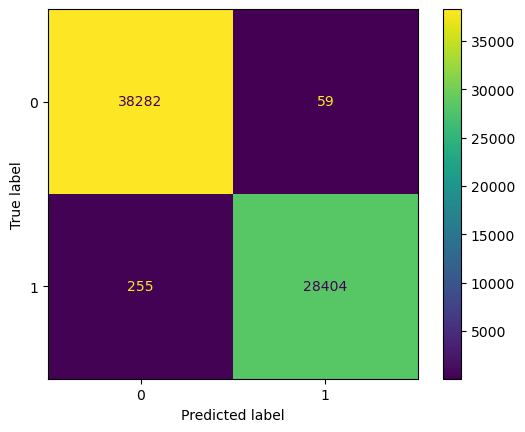

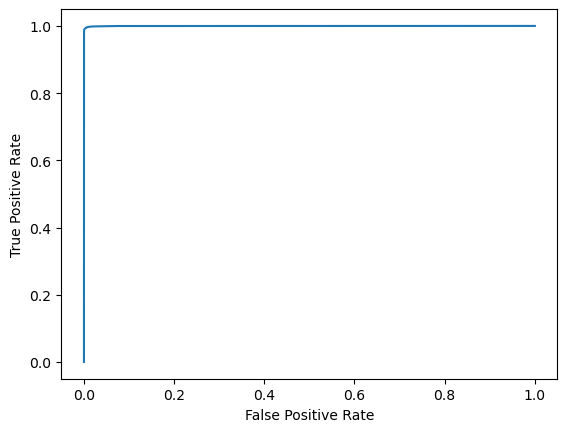

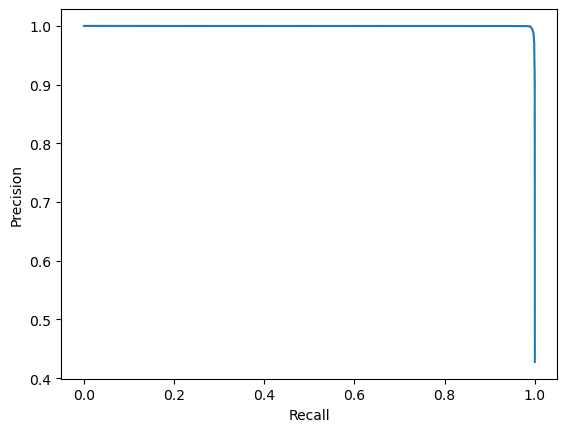

In [236]:
write_plots(train_plots, mpath, "train")

In [224]:
valid_metrics = metrics(y_valid, validpreds, validproba)
valid_plots = plots(y_valid, validpreds, validproba)
print("Validation metrics:")
print(valid_metrics)

Validation metrics:
{'roc_auc': 0.8062607457502112, 'average_precision': 0.7413504559859181, 'accuracy': 0.7399696969696969, 'precision': 0.6959354199121938, 'recall': 0.6962805526036132, 'f1': 0.6961079434784149}


In [237]:
write_metrics(valid_metrics, mpath, "valid")

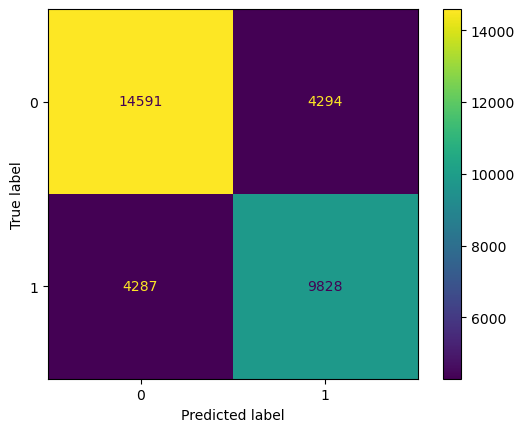

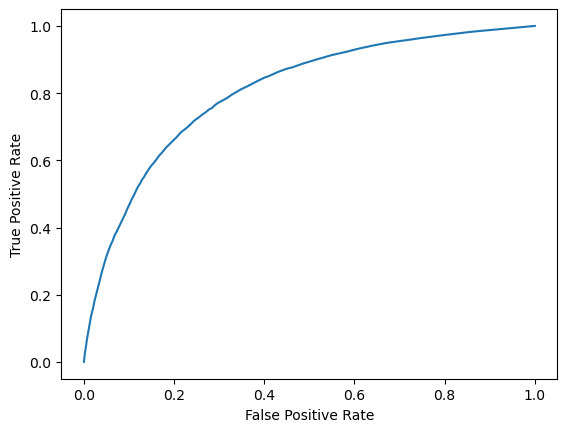

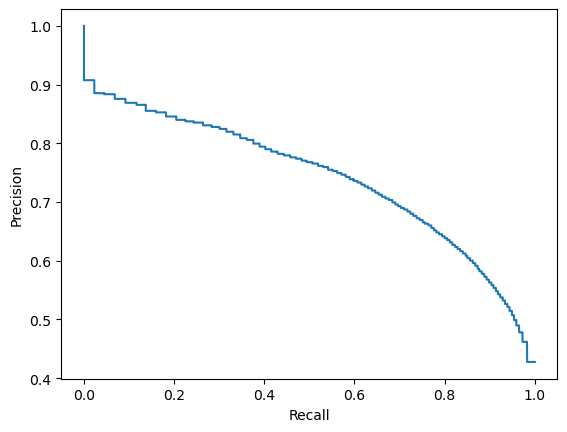

In [238]:
write_plots(valid_plots, mpath, "train")

In [240]:
!ls -lR artifacts

total 0
drwxr-xr-x  8 rahul  staff  256 Nov 18 02:51 baseline_rf
drwxr-xr-x  4 rahul  staff  128 Nov 18 02:30 everybody_dies
drwxr-xr-x  4 rahul  staff  128 Nov 18 02:32 noone_dies

artifacts/baseline_rf:
total 144
-rw-r--r--  1 rahul  staff  17785 Nov 18 02:51 cm_train.png
-rw-r--r--  1 rahul  staff     39 Nov 18 02:43 params.json
-rw-r--r--  1 rahul  staff  18574 Nov 18 02:51 pr_train.png
-rw-r--r--  1 rahul  staff  20315 Nov 18 02:51 roc_train.png
-rw-r--r--  1 rahul  staff    193 Nov 18 02:50 train.json
-rw-r--r--  1 rahul  staff    193 Nov 18 02:51 valid.json

artifacts/everybody_dies:
total 16
-rw-r--r--  1 rahul  staff  108 Nov 18 02:29 train.json
-rw-r--r--  1 rahul  staff  108 Nov 18 02:29 valid.json

artifacts/noone_dies:
total 16
-rw-r--r--  1 rahul  staff  76 Nov 18 02:31 train.json
-rw-r--r--  1 rahul  staff  76 Nov 18 02:31 valid.json


### Baseline Model Inference as a separate pipeline

In [185]:
transtestdata, les = transformed_features(
    pd.concat([X[cat_cols], testdata[cat_cols]], axis=0),
    testdata,
    cat_cols,
    cabin_t(testdata.cabin),
    ticket_t(testdata.ticket),
    les
)
transtestdata

,sibsp,pclass,age,name,fare,parch,cabin,ticket,sex,embarked
passengerid,,,,,,,,,,
100000,0,3,19.0,"Holliday, Daniel",63.01,0,45442,24745,1,2
100001,0,3,53.0,"Nguyen, Lorraine",5.81,0,45442,13264,0,2
100002,0,1,19.0,"Harris, Heather",38.91,0,13085,25990,0,0
100003,0,2,25.0,"Larsen, Eric",12.93,0,45442,314011,1,2
100004,0,1,17.0,"Cleary, Sarah",26.89,2,16911,26203,0,0
...,...,...,...,...,...,...,...,...,...,...
199995,0,3,27.0,"Cash, Cheryle",10.12,0,45442,7686,0,1
199996,1,1,59.0,"Brown, Howard",68.31,0,45442,13004,1,2
199997,0,3,47.0,"Lightfoot, Cameron",10.87,0,45442,4383317,1,2


In [186]:
finaltestdata = final_imputed_features(dropped_features(engineered_features(
    transtestdata,
    family(transtestdata.sibsp, transtestdata.parch),
), drop_cols))
finaltestdata

,pclass,age,fare,cabin,sex,embarked,family
passengerid,,,,,,,
100000,3,19.0,63.01,45442,1,2,0
100001,3,53.0,5.81,45442,0,2,0
100002,1,19.0,38.91,13085,0,0,0
100003,2,25.0,12.93,45442,1,2,0
100004,1,17.0,26.89,16911,0,0,2
...,...,...,...,...,...,...,...
199995,3,27.0,10.12,45442,0,1,0
199996,1,59.0,68.31,45442,1,2,1
199997,3,47.0,10.87,45442,1,2,0


In [187]:
rf.predict(finaltestdata)

array([0, 1, 1, ..., 0, 1, 1])